In [1]:
import pandas as panda


from sklearn.model_selection import learning_curve, train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, confusion_matrix
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


from matplotlib import pyplot as plot
import seaborn as sns


from numpy import bincount, linspace, mean, std, arange, squeeze

import itertools, time, datetime

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
remote_location = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"


In [3]:
def downLoadData():
    """
    
    Downloads the excel data from remote location. Reads one particular sheet, converts all columns names 
    to lower case and then returns the data
    
    """

    data = panda.read_excel(remote_location,sheet_name = "Data", header = 1)

    data.rename(str.lower, inplace = True, axis = 'columns')

    print(data.dtypes)

    return data

data = downLoadData()

id                            int64
limit_bal                     int64
sex                           int64
education                     int64
marriage                      int64
age                           int64
pay_0                         int64
pay_2                         int64
pay_3                         int64
pay_4                         int64
pay_5                         int64
pay_6                         int64
bill_amt1                     int64
bill_amt2                     int64
bill_amt3                     int64
bill_amt4                     int64
bill_amt5                     int64
bill_amt6                     int64
pay_amt1                      int64
pay_amt2                      int64
pay_amt3                      int64
pay_amt4                      int64
pay_amt5                      int64
pay_amt6                      int64
default payment next month    int64
dtype: object


In [4]:
## check for varied data types. there may be alphabetical data types or numeric data written as string eg "4"".
## in such cases reformatting may be required
print(data.dtypes.value_counts()) ## all values are numeric and no formatting of data types are required in that case

int64    25
dtype: int64


In [5]:
data.shape

(30000, 25)

In [6]:

## since all fields are numeric we can get away with normal describe. else we would have required describe(include='all')
data.describe()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000




There are simply 25 columns , all numeric values. No further feature selection or extraction may be required. We will go ahead and run algorithms deirectly and calculate accuracies.

However before we can do that we will check for class bias. Our target attribute is 'deaful', we will check for the value count for the same to see if our data sets is skewed towards one particular class. 

We can see there are almost 4times cases of non default versus default cases. Lets proceed with these analysis and check if we would require to account for class bias during model evaluation

Additionally, we would also drop the id column, since it adds no value other than row count


In [7]:
data['default payment next month'].value_counts()

data.drop(['id'], inplace=True, axis =1)

'id' not in data.columns.tolist()

True

In [8]:
## divide up our x and y axis

_y_target = data['default payment next month'].values

columns = data.columns.tolist()
columns.remove('default payment next month')

_x_attributes = data[columns].values


## meaning of stratify = _y_target. returns test and training data having the same proportions of class label '_y_target'
_x_train,_x_test,_y_train, _y_test = train_test_split(_x_attributes, _y_target, test_size =0.30, stratify = _y_target, random_state = 1)

## lets check the distribution. we can see 4times the lower value as was the case before as well. train/test set distributed well
print("label counts in y train %s" %bincount(_y_train))
print("label counts in y test %s" %bincount(_y_test))

label counts in y train [16355  4645]
label counts in y test [7009 1991]


In [9]:
class CodeTimer:
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))

In [10]:
## cv is essentially value of K in k fold cross validation
    
## n_jobs = 1 is  non parallel execution    , -1 is all parallel , any other number say 2 means execute in 2 cpu cores

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes")
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()

In [11]:
def runGridSearchAndPredict(pipeline, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
    
    response = {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')
    learning_curve_timer = CodeTimer('learning_curve')
    
    with training_timer:
        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)
            
    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
    print("Accuracy score %s" %accuracy_score(y_test,y_prediction))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    with learning_curve_timer:
        plotLearningCurve(_x_train, _y_train, search.best_estimator_)
    
    response['learning_curve_time'] = learning_curve_timer.took
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
    response['accuracy_score'] = accuracy_score(y_test,y_prediction)
    response['training_time'] = training_timer.took
    
    return response
    

In [12]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plot.imshow(cm, interpolation='nearest', cmap=cmap)
    plot.title(title)
    plot.colorbar()
    tick_marks = arange(len(classes))
    plot.xticks(tick_marks, classes, rotation=45)
    plot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plot.ylabel('True label')
    plot.xlabel('Predicted label')
#     plot.tight_layout()
    plot.show()

We will create a list of classifiers and compare performance. The algorithms selected for classification are as below:

1. Perceptron
2. SVM
3. Logistic Regression
4. SVM Kernel RBF
5. DecisionTrees
5. RandomForest
6. Nearest Neighbour




In [13]:
classifiers = [
    Perceptron(random_state = 1),
    LogisticRegression(random_state = 1),
    DecisionTreeClassifier(random_state = 1, criterion = 'gini'),
    RandomForestClassifier(random_state = 1, criterion = 'gini'),
    KNeighborsClassifier(metric = 'minkowski'),
    SVC(random_state = 1, kernel = 'rbf'),    
]


classifier_names = [
            'perceptron',
            'logisticregression',
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'svc',               
    
]

classifier_param_grid = [
            
            {'perceptron__max_iter': [1,5,8,10], 'perceptron__eta0': [0.5,.4, .2, .1]},
            {'logisticregression__C':[100,200,300,50,20,600]},
            {'decisiontreeclassifier__max_depth':[2,4,6,10,20]},
            {'randomforestclassifier__n_estimators':[2,4,6,10,20]} ,
            {'kneighborsclassifier__n_neighbors':[2,4,6,10,20]},
            {'svc__C':[1], 'svc__gamma':[0.01]},
    
]


    

Grid Search Best parameters  {'perceptron__eta0': 0.5, 'perceptron__max_iter': 8}
Grid Search Best score  0.7795238095238095
Code block 'training' took(HH:MM:SS): 0:00:14.331770
Code block 'testing' took(HH:MM:SS): 0:00:00.008040
Accuracy score 0.5882222222222222
Classification report  
              precision    recall  f1-score   support

          0       0.78      0.66      0.71      7009
          1       0.22      0.35      0.27      1991

avg / total       0.66      0.59      0.62      9000



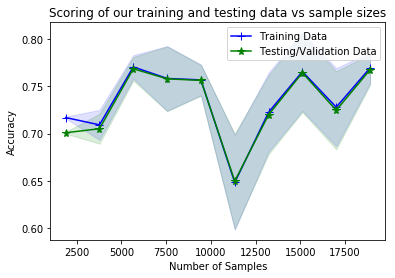

Code block 'learning_curve' took(HH:MM:SS): 0:00:05.625944
Grid Search Best parameters  {'logisticregression__C': 100}
Grid Search Best score  0.8110952380952381
Code block 'training' took(HH:MM:SS): 0:00:21.072240
Code block 'testing' took(HH:MM:SS): 0:00:00.006630
Accuracy score 0.811
Classification report  
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      7009
          1       0.71      0.25      0.37      1991

avg / total       0.80      0.81      0.77      9000



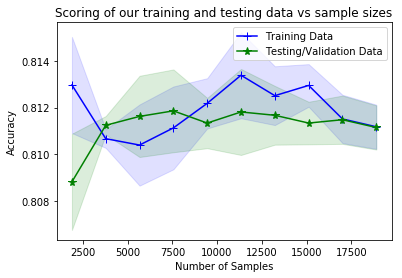

Code block 'learning_curve' took(HH:MM:SS): 0:00:17.702756
Grid Search Best parameters  {'decisiontreeclassifier__max_depth': 4}
Grid Search Best score  0.8212857142857143
Code block 'training' took(HH:MM:SS): 0:00:22.736211
Code block 'testing' took(HH:MM:SS): 0:00:00.007737
Accuracy score 0.8191111111111111
Classification report  
              precision    recall  f1-score   support

          0       0.84      0.95      0.89      7009
          1       0.66      0.37      0.47      1991

avg / total       0.80      0.82      0.80      9000



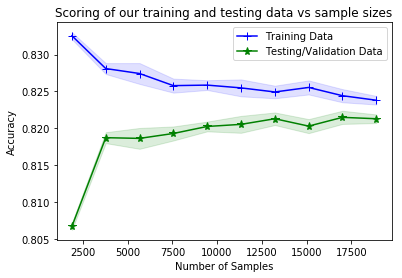

Code block 'learning_curve' took(HH:MM:SS): 0:00:14.971122
Grid Search Best parameters  {'randomforestclassifier__n_estimators': 20}
Grid Search Best score  0.8118571428571428
Code block 'training' took(HH:MM:SS): 0:00:51.963009
Code block 'testing' took(HH:MM:SS): 0:00:00.088689
Accuracy score 0.8113333333333334
Classification report  
              precision    recall  f1-score   support

          0       0.84      0.94      0.89      7009
          1       0.63      0.35      0.45      1991

avg / total       0.79      0.81      0.79      9000



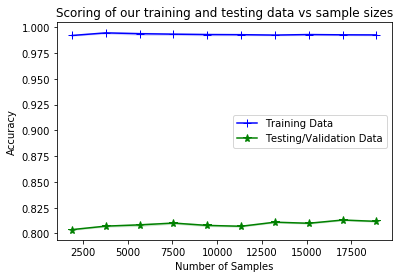

Code block 'learning_curve' took(HH:MM:SS): 0:01:58.776809
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 20}
Grid Search Best score  0.8092380952380952
Code block 'training' took(HH:MM:SS): 0:25:56.300402
Code block 'testing' took(HH:MM:SS): 0:00:16.812126
Accuracy score 0.8134444444444444
Classification report  
              precision    recall  f1-score   support

          0       0.83      0.95      0.89      7009
          1       0.66      0.32      0.43      1991

avg / total       0.79      0.81      0.79      9000



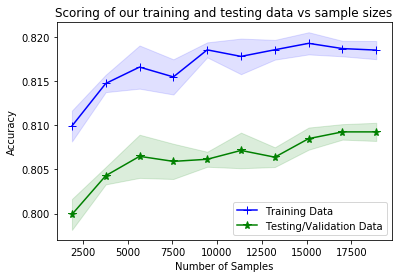

Code block 'learning_curve' took(HH:MM:SS): 0:24:02.544087
Grid Search Best parameters  {'svc__C': 1, 'svc__gamma': 0.01}
Grid Search Best score  0.819
Code block 'training' took(HH:MM:SS): 0:05:44.080015
Code block 'testing' took(HH:MM:SS): 0:00:03.610964
Accuracy score 0.8172222222222222
Classification report  
              precision    recall  f1-score   support

          0       0.83      0.96      0.89      7009
          1       0.68      0.33      0.44      1991

avg / total       0.80      0.82      0.79      9000



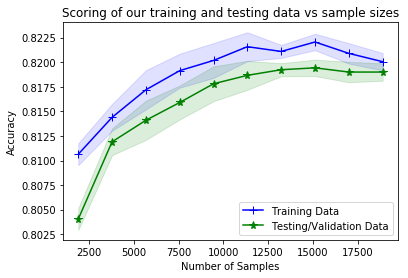

Code block 'learning_curve' took(HH:MM:SS): 0:11:59.490578
Code block 'overalltime' took(HH:MM:SS): 1:12:30.262498
4350262.498044447


In [14]:

timer = CodeTimer(name='overalltime')
model_metrics = {}

with timer:
    for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

        pipeline = Pipeline([
                ('scaler', StandardScaler()),
                (model_name, model)
        ])

        result = runGridSearchAndPredict(pipeline, _x_train, _y_train, _x_test, _y_test, model_param_grid )

        _y_prediction = result['_y_prediction']

        _matrix = confusion_matrix(y_true = _y_test ,y_pred = _y_prediction)

        model_metrics[model_name] = {}
        model_metrics[model_name]['çonfusion_matrix'] = _matrix
        model_metrics[model_name]['training_time'] = result['training_time']
        model_metrics[model_name]['testing_time'] = result['testing_time']
        model_metrics[model_name]['learning_curve_time'] = result['learning_curve_time']
        model_metrics[model_name]['accuracy_score'] = result['accuracy_score']
#         plot_confusion_matrix(_matrix, classes = [0,1])
        
        
print(timer.took)

In [15]:


model_estimates = panda.DataFrame(model_metrics).transpose()

                       accuracy_score  learning_curve_time  testing_time  \
perceptron                   0.588222         5.625944e+03      8.040095   
logisticregression              0.811         1.770276e+04      6.629822   
decisiontreeclassifier       0.819111         1.497112e+04      7.737447   
randomforestclassifier       0.811333         1.187768e+05     88.689083   
kneighborsclassifier         0.813444         1.442544e+06  16812.126418   
svc                          0.817222         7.194906e+05   3610.963611   

                        training_time             çonfusion_matrix  
perceptron               1.433177e+04  [[4595, 2414], [1292, 699]]  
logisticregression       2.107224e+04   [[6810, 199], [1502, 489]]  
decisiontreeclassifier   2.273621e+04   [[6637, 372], [1256, 735]]  
randomforestclassifier   5.196301e+04   [[6602, 407], [1291, 700]]  
kneighborsclassifier     1.556300e+06   [[6692, 317], [1362, 629]]  
svc                      3.440800e+05   [[6705, 304],

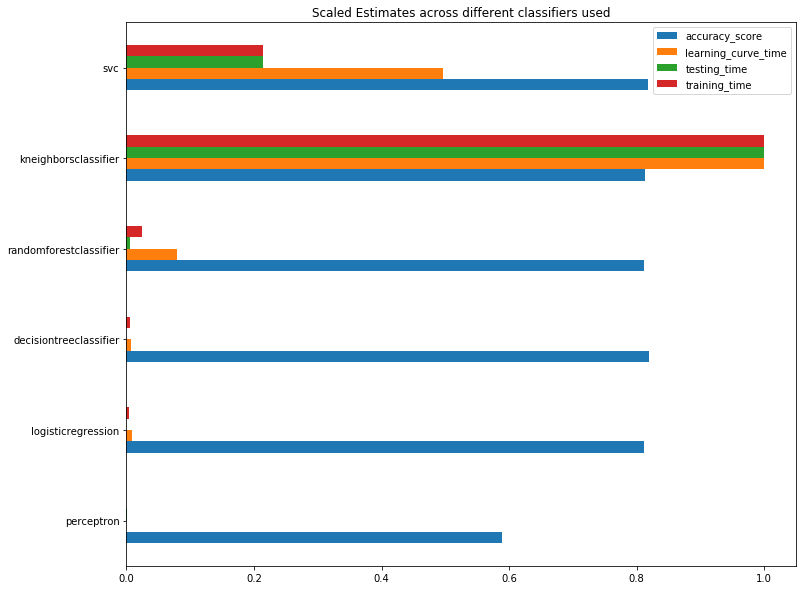

In [16]:

## convert model_metrics into panda data frame
## print out model confusion matrix
## print out across model estimations and accuracy score bar chart


model_estimates['learning_curve_time'] = model_estimates['learning_curve_time'].astype('float64')
model_estimates['testing_time'] = model_estimates['testing_time'].astype('float64')
model_estimates['training_time'] = model_estimates['training_time'].astype('float64')
print(model_estimates)
# print(model_estimates['testing_time'],model_estimates['testing_time'].max(), model_estimates['testing_time'].min())
#scaling time parameters between 0 and 1
model_estimates['learning_curve_time'] = (model_estimates['learning_curve_time']- model_estimates['learning_curve_time'].min())/(model_estimates['learning_curve_time'].max()- model_estimates['learning_curve_time'].min())
model_estimates['testing_time'] = (model_estimates['testing_time']- model_estimates['testing_time'].min())/(model_estimates['testing_time'].max()- model_estimates['testing_time'].min())
model_estimates['training_time'] = (model_estimates['training_time']- model_estimates['training_time'].min())/(model_estimates['training_time'].max()- model_estimates['training_time'].min())

print(model_estimates)
model_estimates.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()